# Strucanti

Before doing anything, we want to create a variable indicating the initial working directory of the jupyter notebook file.

In [1]:
WORKDIR = !pwd
WORKDIR = WORKDIR[0]

%cd $WORKDIR

/home/nizarmah/Documents/Learning/Capstone/strucanti


## Importing Libraries

In [2]:
import sys
import os, shutil

import re

import time
import subprocess

from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA

In addition, we need to make some changes to the libraries, such as increasing *dpi* for `matplotlib`.

In [3]:
mpl.rcParams['figure.dpi']= 300

Most of pandas functions require a `RandomState`. To keep it consistent for anyone who runs the jupyter notebook to get the same results, we will be setting a global `RANDOM_STATE` variable.

In [4]:
RANDOM_STATE = 42

## Reading Data

We have two different datasets, one `bib-40` and the other is `bib-95`.

Therefore, we're going to want to make it easy to deal with both.

In [5]:
list_dataset_filename = ['dataset_astral-scopedom-seqres-gd-sel-gs-bib-40-2.0.7.csv',
                            'dataset_astral-scopedom-seqres-gd-sel-gs-bib-95-2.0.7.csv']

dataset_filename = list_dataset_filename[1]
dataset_name = os.path.splitext(dataset_filename)[0]

dataset = pd.read_csv(dataset_filename)
dataset.shape

(29556, 482)

Let us take a small look at our dataset.

In [6]:
dataset

,sid,class,folds,superfamilies,families,sequence,3_h,5_e,7_E,9_h,...,4645_H,4657_H,4677_h,4881_H,4899_H,4913_H,5257_h,5273_H,6417_H,6419_H
0,d1ux8a_,a,1,1,1,napyeaigeellsqlvdtfyervashpllkpifpsdltetarkqkq...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,d1dlwa_,a,1,1,1,slfeqlggqaavqavtaqfyaniqadatvatffngidmpnqtnkta...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,d1dlya_,a,1,1,1,slfaklggreaveaavdkfynkivadptvstyfsntdmkvqrskqf...,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d2gkma_,a,1,1,1,gllsrlrkrepisiydkiggheaievvvedffvrvladdqlsaffs...,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,d1ngka_,a,1,1,1,ksfydavggaktfdaivsrfyaqvaedevlrrvypeddlagaeerl...,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29551,d5lj3n2,g,100,1,1,nepppniceqclgdeanirmtkipqgseckictlpftlyhfktskr...,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29552,d2k0aa1,g,101,1,1,srhqfdlimclkqpgvqtgllcekcdgkcpicdsyvrpkrkvrvce...,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29553,d5lqwy_,g,101,1,1,fdlimclkqpgvqtgllcekcdgkcpicdsyvrpkrkvrvcencsf...,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29554,d5syba_,g,101,1,1,akhhpdlifcrkqagvaigrlcekcdgkcvicdsyvrpstlvricd...,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As you can see, we have a **sparse dataset**

If we further take a look at the dataset, we can see that the dataset is sorted by class, folds, superfamilies, then families. However, this can influence our model's accuracy and variance when predicting our data as the train and test splits will not contain a balanced distribution of the classes, folds, superfamilies and families.

Therefore, it is important that we shuffle our dataset before we start working with it.

> Please Note that we will be resetting the index after sampling

In [7]:
dataset = dataset.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

So, let's take another look now at our dataset.

In [8]:
dataset

,sid,class,folds,superfamilies,families,sequence,3_h,5_e,7_E,9_h,...,4645_H,4657_H,4677_h,4881_H,4899_H,4913_H,5257_h,5273_H,6417_H,6419_H
0,d1m9sa3,b,34,11,1,rydkmeydkgvtayarvrnasgnsvwtkpyntagakhvnklsvyqg...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,d2gpca2,d,44,1,0,ngggeptgkvadeinasfgsfakfkeeftnvavghfgsgwawlvkd...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,d1ekxa2,c,78,1,1,rldnlhvamvgdlkygrtvhsltqalakfdgnrfyfiapdalampq...,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d4ogna_,a,42,1,1,dgavttsqipaseqetlvrpkplllkllksvgaqkdtytmkevlfy...,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,d5awxa1,c,45,1,0,aipikhfpkhvadlhassgfteefeevqsctvdlgitadssnhpdn...,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29551,d4m1na_,d,20,1,1,siakkrlaqeraewrkdhpagfsakyspmsdgkgldimkwickipg...,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29552,d1bafl1,b,1,1,1,qivltqspaimsaspgekvtmtcsasssvyymywyqqkpgssprll...,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29553,d1kyza1,a,4,5,29,hisdeeanlfamqlasasvlpmilksaleldlleiiakagpgaqis...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29554,d4cr2i3,c,37,1,20,lsigtleeiidddhaivtsptmpdyyvsilsfvdkellepgcsvll...,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking for Missing Data

In [9]:
dataset_nullcheck = dataset.isnull().any()

null_columns = dataset_nullcheck[dataset_nullcheck == True]

print("Number of columns that contain null values :", len(null_columns))
print("Names of columns that contain null values :", null_columns)

Number of columns that contain null values : 0
Names of columns that contain null values : Series([], dtype: bool)


As you can see, there are no _column names_ that contain any missing data.

This shows that the columns we have don't have any missing data.

## Checking for Categorical Values

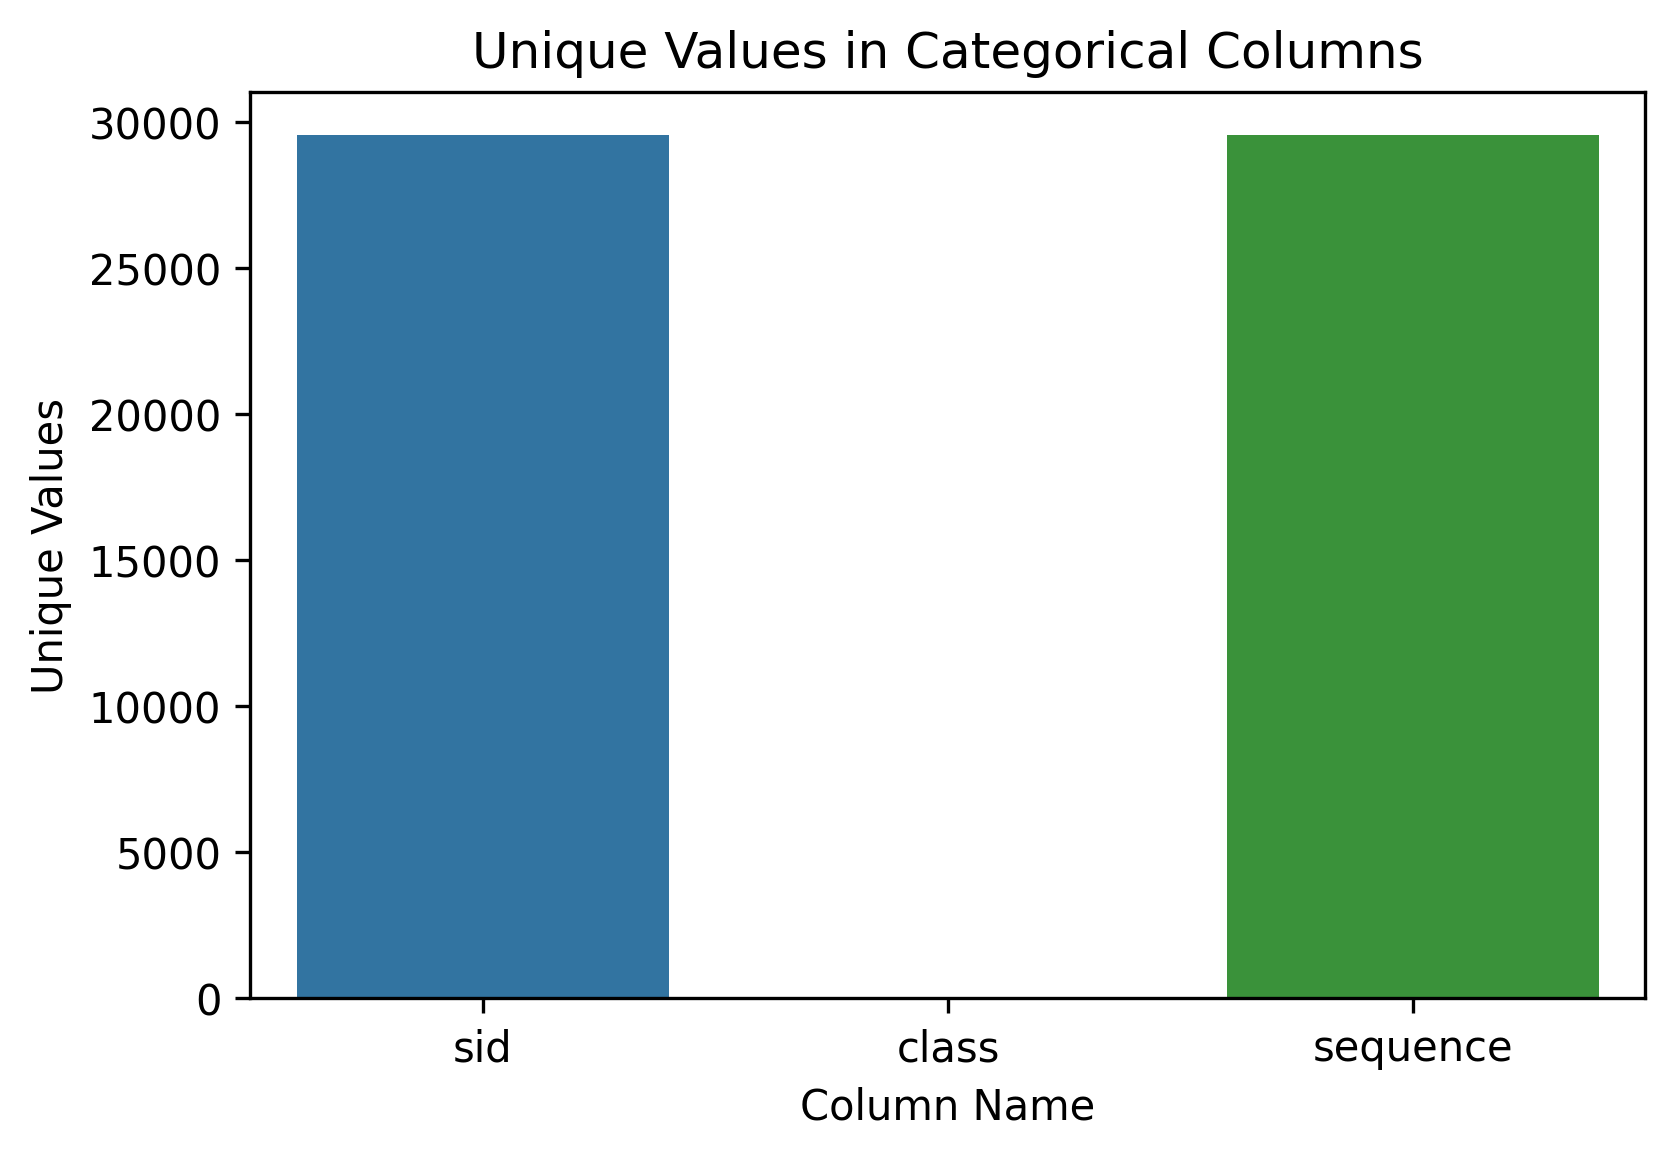

In [10]:
categorical_cols = [ col for col in dataset.columns if dataset[col].dtype == 'object' ]

sns.barplot(x=categorical_cols, y=dataset[categorical_cols].nunique())

plt.title('Unique Values in Categorical Columns')
plt.xlabel('Column Name')
plt.ylabel('Unique Values')
plt.show()

As you can tell, `sid` and `sequence` columns are as frequent as the entries that we have. In addition, they are the sequence id, and the sequence itself.

Therefore, we will disregard them.

So, we have only one categorical column, which is the target or the label `class`.

So, let us check what are the _unique_ values we have in `class`. 

In [11]:
dataset['class'].unique()

array(['b', 'd', 'c', 'a', 'e', 'f', 'g'], dtype=object)

Here are the percentage frequencies of each class.

In [12]:
def class_percentage_occurance():
    return (dataset['class'].value_counts() * 100 / dataset['class'].size).to_frame(name='Percentage Occurance').T

class_percentage_occurance()

,c,b,d,a,g,e,f
Percentage Occurance,26.904859,25.216538,22.327108,16.703884,5.484504,1.752605,1.610502


It is also important to see the frequency of each class.

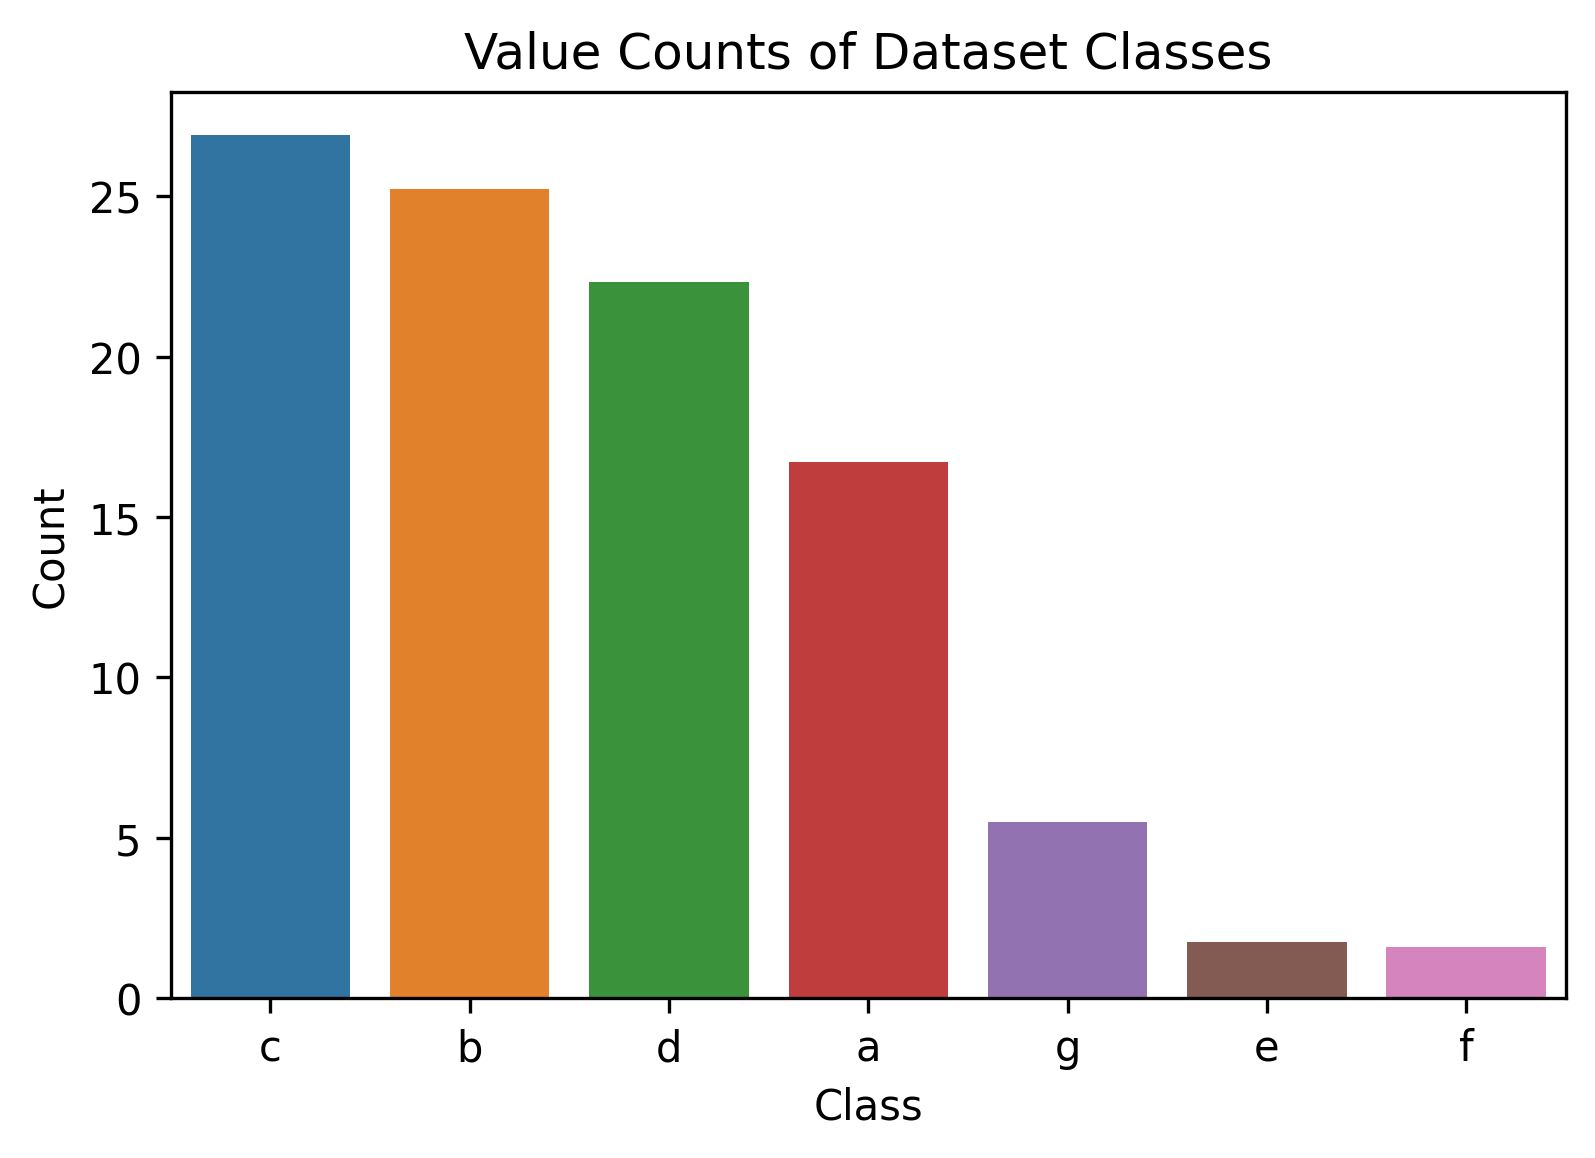

In [13]:
sns.barplot(data=class_percentage_occurance())

plt.title('Value Counts of Dataset Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Disregarding Some Columns

We will be disregarding some columns at this point.

The following categorical columns are not important in our machine learning model:
- `sid`
- `sequence`

The following columns are going to be disregarded for now:
- `folds`
- `superfamilies`
- `families`

In [14]:
unwanted_cols = ['sid', 'sequence', 'folds', 'superfamilies', 'families']

dataset = dataset.drop(unwanted_cols, axis=1)
dataset.shape

(29556, 477)

In [15]:
dataset.head(10)

,class,3_h,5_e,7_E,9_h,11_E,13_e,15_E,17_h,19_H,...,4645_H,4657_H,4677_h,4881_H,4899_H,4913_H,5257_h,5273_H,6417_H,6419_H
0,b,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,c,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,c,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,a,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,c,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,a,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,b,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,d,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Disregarding Some Classes

According to the HCADB we are using, the clusters were collected from the following four classes:
- `a`
- `b`
- `c`
- `d`

Therefore, we will be keeping those classes and disregarding the rest

In [16]:
def trim_dataset(dataset, classes):
    """
    Reduces the dataset by keeping the classes specified, and dropping the rest
    """
    # using .loc would later on avoid the SettingWithCopyWarning that would appear with LabelEncoding
    # basically it helps to avoids returning a copy of the DataFrame
    return dataset[dataset['class'].isin(classes)].loc[:, dataset.columns]

wanted_classes = ['a', 'b', 'c', 'd']

dataset = trim_dataset(dataset, wanted_classes)

class_percentage_occurance()

,c,b,d,a
Percentage Occurance,29.516351,27.664155,24.494265,18.325229


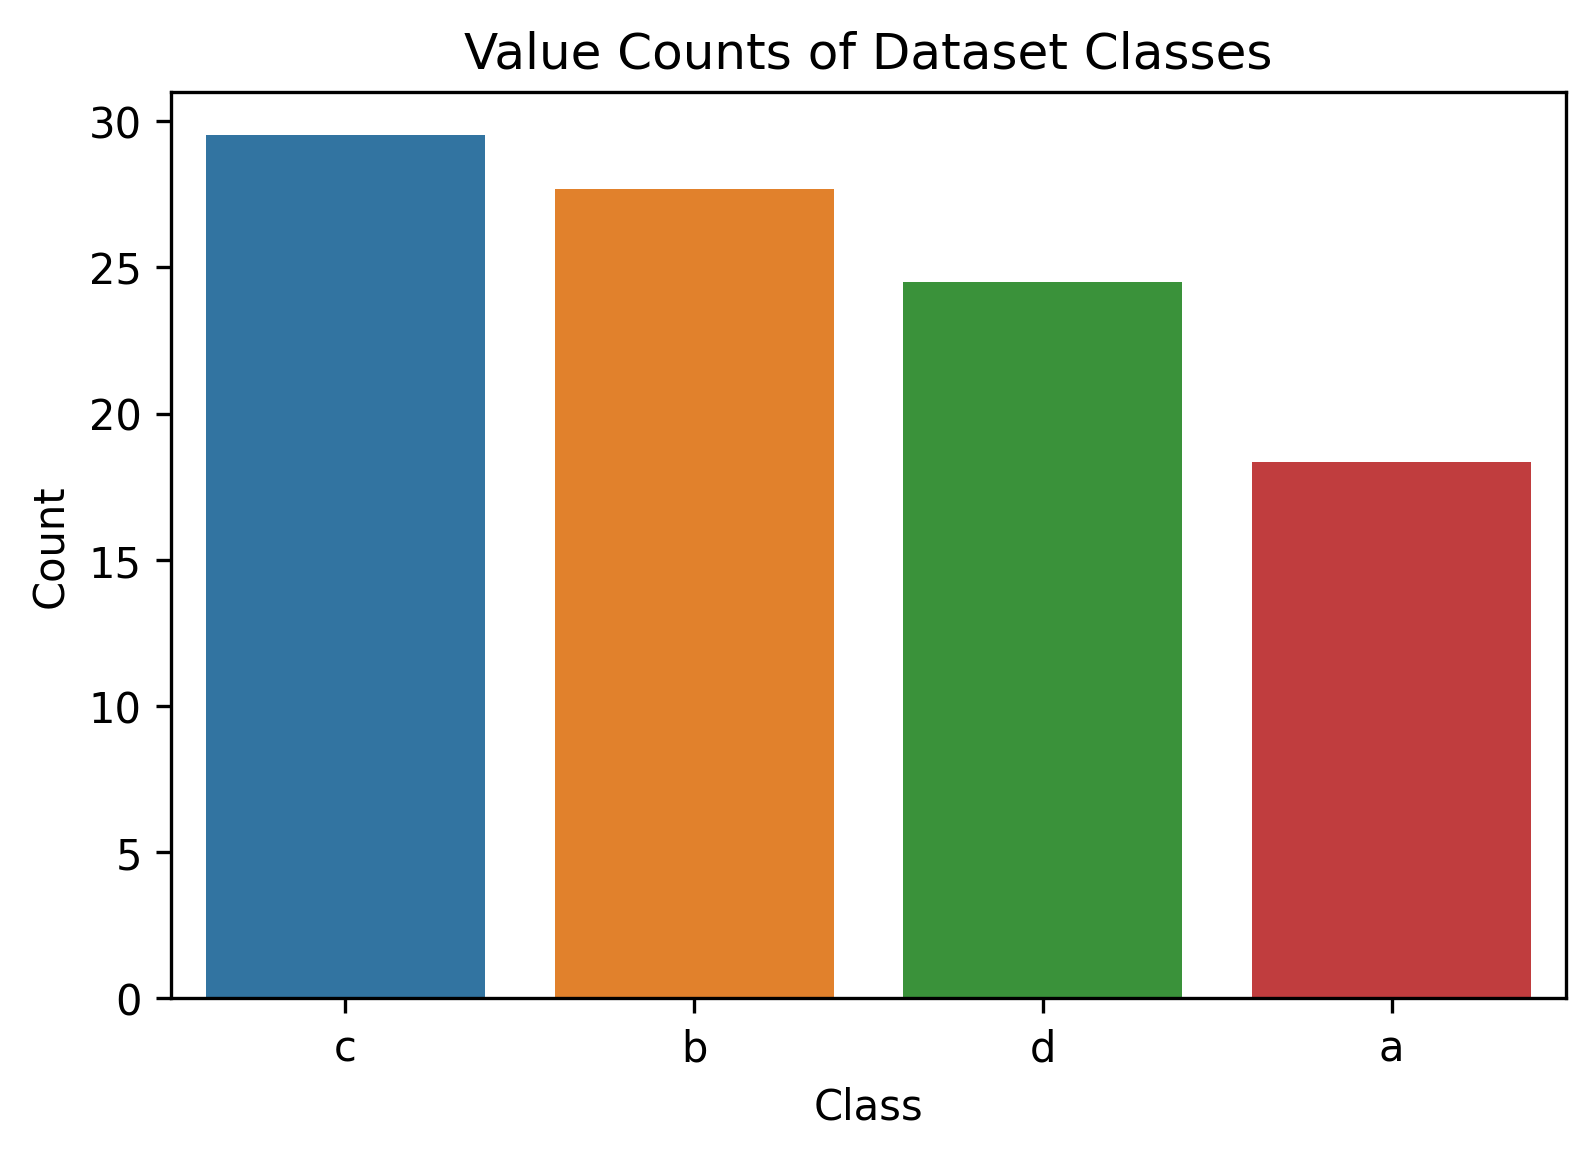

In [17]:
sns.barplot(data=class_percentage_occurance())

plt.title('Value Counts of Dataset Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [18]:
dataset

,class,3_h,5_e,7_E,9_h,11_E,13_e,15_E,17_h,19_H,...,4645_H,4657_H,4677_h,4881_H,4899_H,4913_H,5257_h,5273_H,6417_H,6419_H
0,b,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,c,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,c,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29551,d,2.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29552,b,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29553,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29554,c,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Running mRMR on Dataset

> If you already have the `mRMR/queries` necessary, don't run the mRMR feature selection 

`Python` libraries for `mRMR` are discontinued and unreliable. 
In addition, after comparing a `C/C++` library for `mRMR` with the one used in `R`, I decided to write my own script to execute `mRMR` on a dataset using `R`.

The R script that will be used is in `mRMR/mRMR.R`.
It takes two arguments / parameters:
1. `dataset_path`
2. `number_features`

We will be using `subprocesses` to run the `Rscript`. In addition, we will be piping its `stdout` to a directory.

We will be running `mRMR` with `number_features` from 1 to 476.

In addition, we will be running `mRMR` including the following *classes*:
- Against All (such as: a, not a)
- Pairwise (such as: a, b)
- All Classes (a, b, c, d)

In order to ease the creation of the dataset for the above `mRMR` runs, we will create a function to do that for us.

In [19]:
def label_encode_dataset(dataset, classes):
    """
    Label Encodes the specified classes in the Dataset
    The classes parameter can be `list` or `str`
    
    If the type(classes) is `list`
    The dataset is first reduced to only match the classes specified
    Then it is Label Encoded
    
    If the type(classes) is `str`
    We label encode the classes by `class` and `not class` (1, 0 respectively)
    """
    dataset_clone = dataset.copy(deep=True)
    
    if type(classes) is list:
        dataset_clone = trim_dataset(dataset_clone, classes)
        
        label_encoder = LabelEncoder()
        dataset_clone['class'] = label_encoder.fit_transform(dataset_clone['class'])
    elif type(classes) is str:
        dataset_clone['class'] = dataset_clone['class'].map(lambda x: int(classes == x))
    else:
        raise Exception('Unsupported Argument Type \'classes\'; Should be \'list\' or \'str\'')
    
    return dataset_clone

Also, in order to ease the running of `mRMR` on the different _label encoded_ datasets, we will be creating a function that queries certain classes to have `mRMR` run on them automatically.

In [20]:
def subquery_mRMR(task):
    """
    Run the mRMR script on the Task
    Task is of form (subquery_dir, num_features)
    """
    subquery_dir, num_features = task
    
    script_path = 'mRMR.R'
    
    dataset_path = '{0}/dataset.csv'.format(subquery_dir)
    output_file = '{0}/mRMR/out/{1}_features.mrmr'.format(subquery_dir, num_features)
    
    subprocess.call(['Rscript', script_path, dataset_path, str(num_features), output_file])

def query_mRMR(dataset, dataset_name, query_label, subqueries, jobs=1):
    """
    Queries mRMR feature selection on dataset
    
    Script path is mRMR/mRMR.R
    Therefore, we save the query results next to it in mRMR/queries/
    
    However, we might have different datasets used, so we use
    mRMR/queries/dataset_name/query_label
    In order to save the output 
    
    If the query_label directory exists, we delete it and its content
    We create the query_label directory, then go over every subquery,
    We get the subquery path, and the number of features we want to execute
    throw that all in a tasks pool, then run the pool on mutliple processors
    """
    start_time = time.time()
    
    query_dir = 'queries/{0}/{1}'.format(dataset_name, query_label)
    
    if os.path.exists(query_dir):
        shutil.rmtree(query_dir)
    
    os.makedirs(query_dir)
    
    tasks = [] 
    for subquery in subqueries:
        subquery_label = '_'.join([ str(i) for i in subquery ]) \
                            if type(subquery) is list else \
                                '{0}_!{0}'.format(subquery)
        
        subquery_dir = '{0}/{1}'.format(query_dir, subquery_label)
        os.makedirs('{0}/mRMR/out'.format(subquery_dir))
        
        dataset_path = '{0}/dataset.csv'.format(subquery_dir)
        label_encode_dataset(dataset, subquery).to_csv(dataset_path, index=False)
        
        for i in range(1, len(dataset.columns)):
            tasks.append((subquery_dir, i))
            
    with Pool(processes=jobs) as pool:
        pool.map(subquery_mRMR, tasks)
        
    print('Time taken :', (time.time() - start_time))

### Against All

In [ ]:
query_mRMR(dataset, dataset_name, 'against_all', [
    'a',
    'b',
    'c',
    'd'
], jobs=8)

### Pairwise

In [ ]:
query_mRMR(dataset, dataset_name, 'pairwise', [
    ['a', 'b'],
    ['a', 'c'],
    ['a', 'd'],
    ['b', 'c'],
    ['b', 'd'],
    ['c', 'd']
], jobs=6)

### All Classes

In [ ]:
query_mRMR(dataset, dataset_name, 'all_classes', [
    ['a', 'b', 'c', 'd']
], jobs=4)

## Scoring mRMR Selected Features

After creating different `mRMR` feature selections with different `num_features` taken everytime, we have to score the results of each `mRMR` run for the different runs in order to identify which run performed the best.

Then, we'll take that run's `mRMR` selected features to use them in our model later on.

In addition, we want to run that on the different datasets we have and the different `mRMR` runs, whether *pairwise*, *against all*, or *all classes*. Therefore, we will specify which `query_labels` we want to execute the _cross validation_ on.

In [21]:
def read_mRMR_features(mrmr_file_path):
    """
    Read the output of the mRMR Rscript
    """
    with open(mrmr_file_path, 'r') as file:
        return [ line.rstrip() for line in file.readlines() ]
        
def score_mRMR_features(model, dataset, mrmr_features, folds=10, jobs=-1):
    """
    Running Cross Validation on a Specific Model
    Along with Dataset and Specific mRMR Selected Features
    """
    return cross_val_score(model, dataset[mrmr_features], dataset['class'], cv=folds, n_jobs=jobs)

def plot_scores(scores, plot_path, prefix='', xlabel='Number of Features', ci=95):
    """
    After we have the *scores* for each *percentage*, 
    we want to convert it into a DataFrame of (*n# features*, *score*) 
    and plot the different scores, along with their mean and error bars.
    """
    scores_df = pd.DataFrame([ [key, score] for key in scores.keys() 
                                                           for score in scores[key] ],
                                    columns=['key', 'score'])
    
    sns.pointplot(x='key', y='score', data=scores_df, capsize=.2, ci=ci)
    sns.stripplot(x='key', y='score', data=scores_df)

    plot_title = 'Score'
    if len(prefix) > 0:
        plot_title = '{0} : {1}'.format(prefix, plot_title)
    
    plt.title(plot_title)
    
    plt.xlabel(xlabel, size=8)
    plt.xticks(size=8)
    
    plt.ylabel('Cross Validation Score', size=8)
    plt.yticks(size=8)
    
    plt.savefig(plot_path)
    plt.clf()

def score_mRMR_queries(model, model_name, dataset_name, query_labels, 
                            runs_range=range(1, 477), folds=10, jobs=-1):
    """
    For the specified queries under the dataset_name
    Run Cross Validation Scoring on the mRMR Rscript Results
    According to a certain Range / Ratio
    
    The ratio can be a normal percentage, or it can be something else
    like from 1 to 476 with a step of 1
    meaning all number_features are included
    """
    dataset_dir = 'queries/{0}'.format(dataset_name)
    
    for query in os.listdir(dataset_dir):
        if query in query_labels:
            query_dir = '{0}/{1}'.format(dataset_dir, query)
            
            for subquery in os.listdir(query_dir):
                subquery_scores = dict()
                
                subquery_dir = '{0}/{1}'.format(query_dir, subquery)
                
                dataset_file = '{0}/dataset.csv'.format(subquery_dir)
                dataset = pd.read_csv(dataset_file)
                
                for i in runs_range:
                    num_features = int((476 * i) / (runs_range.stop - 1))
                    
                    mrmr_file = '{0}/mRMR/out/{1}_features.mrmr'.format(subquery_dir, num_features)
                    mrmr_features = read_mRMR_features(mrmr_file)
                    
                    subquery_scores[num_features] = score_mRMR_features(model, dataset, 
                                                        mrmr_features, folds=folds, jobs=jobs)
                
                plot_scores(subquery_scores, '{0}/mRMR/{1}_plot.png'.format(subquery_dir, model_name),
                                    prefix=subquery, xlabel='Number of Features')
                
                with open('{0}/mRMR/{1}_scores.txt'.format(subquery_dir, model_name), 'w+') as file:
                    for key, value in subquery_scores.items():
                        print('{0} : {1}'.format(key, ','.join([ str(v) for v in value ])), 
                                  file=file)

In [ ]:
score_mRMR_queries(RandomForestClassifier(random_state=RANDOM_STATE), "random_forest", dataset_name,
                    [ 'against_all', 'pairwise', 'all_classes' ], runs_range=range(5, 101, 5), jobs=8)

## Scoring PCA Features

In [22]:
def score_pca_subqueries(model, dataset, variance_range, folds=10):
    subquery_scores = dict()
    
    X = dataset.drop('class', axis=1)
    y = dataset['class']

    splitter = StratifiedKFold(n_splits=folds)
    
    scaler = StandardScaler()
    
    for variance in variance_range:
        pca = PCA((variance / 100))
        subquery_scores[variance] = dict(scores=[], components=[])
        
        for train_index, test_index in splitter.split(X, y):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]
            scaler.fit(X_train)
            X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
            
            pca.fit(X_train)
            X_train, X_test = pca.transform(X_train), pca.transform(X_test)

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            
            subquery_scores[variance]['scores'].append(score)
            subquery_scores[variance]['components'].append(pca.n_components_)
            
    return subquery_scores

def score_pca_queries(model, model_name, dataset_name, query_labels, 
                          variance_range=range(80, 96, 5), folds=10):
    """
    """
    dataset_dir = 'queries/{0}'.format(dataset_name)

    for query in os.listdir(dataset_dir):
        if query in query_labels:
            query_dir = '{0}/{1}'.format(dataset_dir, query)

            for subquery in os.listdir(query_dir):
                subquery_dir = '{0}/{1}'.format(query_dir, subquery)
                
                pca_dir = '{0}/pca'.format(subquery_dir)
                if not os.path.exists(pca_dir):
                    os.makedirs(pca_dir)
                
                dataset_file = '{0}/dataset.csv'.format(subquery_dir)
                dataset = pd.read_csv(dataset_file)
                
                subquery_scores = score_pca_subqueries(model, dataset, variance_range, folds=folds)
                
                plot_scores({ k: v['scores'] for k, v in subquery_scores.items() }, 
                                '{0}/{1}_plot.png'.format(pca_dir, model_name),
                                    prefix=subquery, xlabel='PCA Variance Retain')

                with open('{0}/{1}_scores.txt'.format(pca_dir, model_name), 'w+') as file:
                    for key, value in subquery_scores.items():
                        print('{0} : {1}'.format(key, ','.join([ str(v) for v in value['scores'] ])), 
                                  file=file)

                with open('{0}/{1}_components.txt'.format(pca_dir, model_name), 'w+') as file:
                    for key, value in subquery_scores.items():
                        print('{0} : {1}'.format(key, ','.join([ str(v) for v in value['components'] ])), 
                                  file=file)

In [23]:
score_pca_queries(RandomForestClassifier(random_state=RANDOM_STATE), "random_forest", dataset_name,
                    [ 'against_all', 'pairwise', 'all_classes' ], variance_range=range(5, 96, 20))

<Figure size 1800x1200 with 0 Axes>